25/02/07 00:23:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


DataFrame[message: string]


# Main

In [135]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType


In [ ]:
spark = SparkSession.builder\
    .appName("data_clean_hdfs") \
    .getOrCreate()


In [137]:
filePath = "hdfs://localhost:9000/user/atul/news_data/input/news_data_1.json"

df = spark.read.json(filePath)
df.show() 


+--------------------+--------------+--------------------+--------------------+----------+
|             Content|       Dataset|                  ID|             Summary|Unnamed: 0|
+--------------------+--------------+--------------------+--------------------+----------+
|New York police a...|CNN/Daily Mail|f49ee725a0360aa68...|Police have inves...|         0|
|By . Ryan Lipman ...|CNN/Daily Mail|808fe317a53fbd313...|Porn star Angela ...|         1|
|This was, Sergio ...|CNN/Daily Mail|98fd67bd343e58bc4...|American draws in...|         2|
|An Ebola outbreak...|CNN/Daily Mail|e12b5bd7056287049...|World Health Orga...|         3|
|By . Associated P...|CNN/Daily Mail|b83e8bcfcd5141984...|A sinkhole opened...|         4|
|Jerusalem woke up...|CNN/Daily Mail|9c2b9de4b8928f63b...|Two Palestinians ...|         5|
|An Australian fat...|CNN/Daily Mail|550c7ea14b4ec91db...|Zia Abdul Haq is ...|         6|
|A mother whose pr...|CNN/Daily Mail|c6dbfd89aa8485511...|Jocelyn Bennett a...|         7|

In [138]:
df.count()

1000

In [139]:
df = df.dropDuplicates()
df.count()

1000

In [140]:
df = df.dropna()
df.count()

1000

In [141]:
df.dtypes

[('Content', 'string'),
 ('Dataset', 'string'),
 ('ID', 'string'),
 ('Summary', 'string'),
 ('Unnamed: 0', 'bigint')]

In [142]:
df = df.drop("Dataset","ID","Unnamed: 0")
df.show(5)

+--------------------+--------------------+
|             Content|             Summary|
+--------------------+--------------------+
|LONDON, England (...|Britain leads the...|
|By . Nick Mcdermo...|Cait Reilly's law...|
|There was never a...|Louis Rumble was ...|
|(CNN) -- A dry an...|Farmers like Don ...|
|The major search ...|A body has been f...|
+--------------------+--------------------+
only showing top 5 rows



# old (ignore)

In [143]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

tokenizer = Tokenizer(inputCol="Content", outputCol="words")
wordsData = tokenizer.transform(df)
wordsData.show(5)

+--------------------+--------------------+--------------------+
|             Content|             Summary|               words|
+--------------------+--------------------+--------------------+
|LONDON, England (...|Britain leads the...|[london,, england...|
|By . Nick Mcdermo...|Cait Reilly's law...|[by, ., nick, mcd...|
|There was never a...|Louis Rumble was ...|[there, was, neve...|
|(CNN) -- A dry an...|Farmers like Don ...|[(cnn), --, a, dr...|
|The major search ...|A body has been f...|[the, major, sear...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [144]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filteredData = remover.transform(wordsData)
filteredData.show(5)

+--------------------+--------------------+--------------------+--------------------+
|             Content|             Summary|               words|            filtered|
+--------------------+--------------------+--------------------+--------------------+
|LONDON, England (...|Britain leads the...|[london,, england...|[london,, england...|
|By . Nick Mcdermo...|Cait Reilly's law...|[by, ., nick, mcd...|[., nick, mcdermo...|
|There was never a...|Louis Rumble was ...|[there, was, neve...|[never, question,...|
|(CNN) -- A dry an...|Farmers like Don ...|[(cnn), --, a, dr...|[(cnn), --, dry, ...|
|The major search ...|A body has been f...|[the, major, sear...|[major, search, l...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [145]:
filteredData.select(filteredData.filtered).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [146]:
# removing more stop stop words

from pyspark.ml.feature import StopWordsRemover

stopwords = StopWordsRemover.loadDefaultStopWords("english")

custom_stopwords = ["", " ","|","cnn","cnn","'",",",".","", "word"]  
all_stopwords = stopwords + custom_stopwords

remover = StopWordsRemover(inputCol="filtered", outputCol="custom_filtered", stopWords=all_stopwords)
new_filteredData = remover.transform(filteredData) 

new_filteredData.select(new_filteredData.filtered).show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [147]:
from pyspark.sql.functions import explode, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# 1. Data Cleaning (lowercase, remove punctuation)
df = df.withColumn("Content", regexp_replace(col("Content"), "[^a-zA-Z0-9\\s]", ""))
df = df.withColumn("Content", lower(col("Content")))

df = df.withColumn("Summary", regexp_replace(col("Summary"), "[^a-zA-Z0-9\\s]", ""))
df = df.withColumn("Summary", lower(col("Summary")))

In [148]:
df.show()

+--------------------+--------------------+
|             Content|             Summary|
+--------------------+--------------------+
|london england cn...|britain leads the...|
|by  nick mcdermot...|cait reillys lawy...|
|there was never a...|louis rumble was ...|
|cnn  a dry and mi...|farmers like don ...|
|the major search ...|a body has been f...|
|nigel edwards chi...|the growing crisi...|
|cnn  the age of t...|microsoft added t...|
|pensacola fla  an...| even though rush...|
|by  damien gayle ...|fujitsu unveiled ...|
|this is a symbol ...|in the days leadi...|
|the grieving fami...|new book flight m...|
|mr muslem was a r...|in the spring of ...|
|tests on three pa...|author jane auste...|
|maer eilyddion yn...|mae warren gatlan...|
|these unusual str...|the structures we...|
|cnn  when it come...|indias punjab sta...|
|jhon jairo velasq...|one of colombias ...|
|focused crawls ar...| president trump ...|
|stoke field on 16...|a forgotten battl...|
|by  mark prigg  p...|groundbrea

In [149]:
tokenizer = Tokenizer(inputCol="Content", outputCol="words")
wordsData = tokenizer.transform(df)
wordsData.select("Content").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# new

In [150]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF


df = df.withColumn("Content", regexp_replace(col("Content"), "[^a-zA-Z0-9\\s]", ""))
df = df.withColumn("Content", lower(col("Content")))

df = df.withColumn("Summary", regexp_replace(col("Summary"), "[^a-zA-Z0-9\\s]", ""))
df = df.withColumn("Summary", lower(col("Summary")))

df.show(n=2,truncate=False)



+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [151]:

tokenizer = Tokenizer(inputCol="Content", outputCol="Content_words")
wordsData = tokenizer.transform(df)

tokenizer = Tokenizer(inputCol="Summary", outputCol="Summary_words")
wordsData = tokenizer.transform(wordsData)


wordsData.show(5)

+--------------------+--------------------+--------------------+--------------------+
|             Content|             Summary|       Content_words|       Summary_words|
+--------------------+--------------------+--------------------+--------------------+
|london england cn...|britain leads the...|[london, england,...|[britain, leads, ...|
|by  nick mcdermot...|cait reillys lawy...|[by, , nick, mcde...|[cait, reillys, l...|
|there was never a...|louis rumble was ...|[there, was, neve...|[louis, rumble, w...|
|cnn  a dry and mi...|farmers like don ...|[cnn, , a, dry, a...|[farmers, like, d...|
|the major search ...|a body has been f...|[the, major, sear...|[a, body, has, be...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [152]:
token_df = wordsData.select('Content_words','Summary_words')
token_df.show(4)

+--------------------+--------------------+
|       Content_words|       Summary_words|
+--------------------+--------------------+
|[london, england,...|[britain, leads, ...|
|[by, , nick, mcde...|[cait, reillys, l...|
|[there, was, neve...|[louis, rumble, w...|
|[cnn, , a, dry, a...|[farmers, like, d...|
+--------------------+--------------------+
only showing top 4 rows



In [153]:
# 3. Stop Word Removal
stopwords = StopWordsRemover.loadDefaultStopWords("english")
custom_stopwords = ["example", "another","cnn","","-","--","–","(cnn)"]
all_stopwords = stopwords + custom_stopwords

remover = StopWordsRemover(inputCol="Content_words", outputCol="Content_filtered", stopWords=all_stopwords)
new_filteredData = remover.transform(token_df)


remover = StopWordsRemover(inputCol="Summary_words", outputCol="Summary_filtered", stopWords=all_stopwords)
new_filteredData = remover.transform(new_filteredData)


In [154]:
new_filteredData.select(new_filteredData.Content_filtered).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [155]:
# 4. Explode the 'filtered' column to count individual words
word_counts = new_filteredData.select(explode(col("Content_filtered")).alias("word")) \
                           .groupBy("word") \
                           .count() \
                           .orderBy(col("count").desc())
                   



In [156]:
# 5. Show the most frequent words
print("Most frequent words after initial stop word removal:")
word_counts.show(truncate=False)

Most frequent words after initial stop word removal:


+------+-----+
|word  |count|
+------+-----+
|said  |4621 |
|one   |1632 |
|people|1328 |
|also  |1235 |
|mr    |1113 |
|new   |1109 |
|time  |1030 |
|years |1009 |
|told  |1002 |
|two   |981  |
|first |962  |
|us    |945  |
|last  |924  |
|may   |827  |
|police|799  |
|like  |793  |
|year  |735  |
|says  |695  |
|made  |667  |
|home  |652  |
+------+-----+
only showing top 20 rows



## sentiment analysis

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.sql.types import StructType, StructField, FloatType
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

try:
    sid = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()


def analyze_sentiment(text):
    if not text:
        return 0.0 
    scores = sid.polarity_scores(text)
    return scores['compound']  

analyze_sentiment_udf = udf(analyze_sentiment, FloatType())


# # Initialize SparkSession
# spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

data = df.select('Summary')
df = data

# Preprocess the Summary column (lowercase, remove punctuation)
df = df.withColumn("Summary", lower(col("Summary")))
df = df.withColumn("Summary", regexp_replace(col("Summary"), "[^a-zA-Z0-9\\s]", ""))


# Apply the sentiment analysis UDF
df = df.withColumn("sentiment_score", analyze_sentiment_udf(col("Summary")))

# Show the results
df.show()




In [ ]:
df.show(10)

+--------------------+---------------+
|             Summary|sentiment_score|
+--------------------+---------------+
|britain leads the...|         0.3612|
|cait reillys lawy...|         -0.872|
|louis rumble was ...|         0.8591|
|farmers like don ...|        -0.6249|
|a body has been f...|         -0.296|
|the growing crisi...|        -0.6908|
|microsoft added t...|         0.4767|
| even though rush...|         0.8913|
|fujitsu unveiled ...|        -0.1027|
|in the days leadi...|            0.0|
+--------------------+---------------+
only showing top 10 rows



In [ ]:
# Stop the SparkSession
spark.stop()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.sql.types import FloatType
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import os

spark = SparkSession.builder.appName("BatchSentimentAnalysis").getOrCreate()

try:
    sid = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vasotre theder_lexicon')
    sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if not text:
        return 0.0
    scores = sid.polarity_scores(text)
    return scores['compound']

analyze_sentiment_udf = udf(analyze_sentiment, FloatType())

# Base paths
# filePath = "hdfs://localhost:9000/user/atul/news_data/input/news_data_1.json"
base_input_path = "hdfs://localhost:9000/user/atul/news_data/input/"
base_output_path = "hdfs://localhost:9000/user/atul/news_data/sentiment_output/"


In [ ]:
num_files = 871 

for i in range(1, num_files + 1):
    input_file_path = f"{base_input_path}news_data_{i}.json"
    output_file_path = f"{base_output_path}news_data_{i}_sentiment.json"

    try:
        df = spark.read.json(input_file_path)

        if df.count() == 0:
            print(f"Skipping empty file: {input_file_path}")
            continue

      
        text_column = "Summary" 

        if text_column not in df.columns:
            print(f"Skipping {input_file_path} as column {text_column} does not exist.")
            continue
        df = df.withColumn(text_column, lower(col(text_column)))
        df = df.withColumn(text_column, regexp_replace(col(text_column), "[^a-zA-Z0-9\\s]", ""))
        df = df.withColumn("sentiment_score", analyze_sentiment_udf(col(text_column)))

    
        df_selected = df.select("Summary", "sentiment_score")

    
        df_selected.write.mode("overwrite").json(output_file_path)

        print(f"Successfully processed and saved: {input_file_path} to {output_file_path}")

    except Exception as e:
        print(f"Error processing {input_file_path}: {e}")


spark.stop()

Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_1.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_1_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_2.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_2_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_3.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_3_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_4.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_4_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_5.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_5_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_6.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_6_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_7.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_7_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_8.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_8_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_9.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_9_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_10.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_10_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_11.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_11_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_12.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_12_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_13.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_13_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_14.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_14_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_15.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_15_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_16.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_16_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_17.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_17_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_18.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_18_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_19.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_19_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_20.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_20_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_21.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_21_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_22.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_22_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_23.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_23_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_24.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_24_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_25.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_25_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_26.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_26_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_27.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_27_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_28.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_28_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_29.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_29_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_30.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_30_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_31.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_31_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_32.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_32_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_33.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_33_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_34.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_34_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_35.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_35_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_36.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_36_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_37.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_37_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_38.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_38_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_39.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_39_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_40.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_40_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_41.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_41_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_42.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_42_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_43.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_43_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_44.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_44_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_45.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_45_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_46.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_46_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_47.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_47_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_48.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_48_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_49.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_49_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_50.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_50_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_51.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_51_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_52.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_52_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_53.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_53_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_54.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_54_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_55.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_55_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_56.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_56_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_57.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_57_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_58.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_58_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_59.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_59_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_60.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_60_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_61.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_61_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_62.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_62_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_63.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_63_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_64.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_64_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_65.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_65_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_66.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_66_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_67.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_67_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_68.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_68_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_69.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_69_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_70.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_70_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_71.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_71_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_72.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_72_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_73.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_73_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_74.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_74_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_75.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_75_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_76.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_76_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_77.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_77_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_78.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_78_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_79.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_79_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_80.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_80_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_81.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_81_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_82.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_82_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_83.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_83_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_84.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_84_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_85.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_85_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_86.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_86_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_87.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_87_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_88.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_88_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_89.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_89_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_90.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_90_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_91.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_91_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_92.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_92_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_93.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_93_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_94.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_94_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_95.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_95_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_96.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_96_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_97.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_97_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_98.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_98_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_99.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_99_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_100.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_100_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_101.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_101_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_102.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_102_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_103.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_103_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_104.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_104_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_105.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_105_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_106.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_106_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_107.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_107_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_108.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_108_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_109.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_109_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_110.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_110_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_111.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_111_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_112.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_112_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_113.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_113_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_114.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_114_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_115.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_115_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_116.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_116_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_117.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_117_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_118.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_118_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_119.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_119_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_120.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_120_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_121.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_121_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_122.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_122_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_123.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_123_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_124.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_124_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_125.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_125_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_126.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_126_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_127.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_127_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_128.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_128_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_129.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_129_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_130.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_130_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_131.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_131_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_132.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_132_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_133.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_133_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_134.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_134_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_135.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_135_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_136.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_136_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_137.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_137_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_138.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_138_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_139.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_139_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_140.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_140_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_141.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_141_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_142.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_142_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_143.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_143_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_144.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_144_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_145.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_145_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_146.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_146_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_147.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_147_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_148.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_148_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_149.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_149_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_150.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_150_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_151.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_151_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_152.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_152_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_153.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_153_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_154.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_154_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_155.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_155_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_156.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_156_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_157.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_157_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_158.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_158_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_159.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_159_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_160.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_160_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_161.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_161_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_162.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_162_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_163.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_163_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_164.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_164_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_165.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_165_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_166.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_166_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_167.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_167_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_168.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_168_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_169.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_169_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_170.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_170_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_171.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_171_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_172.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_172_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_173.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_173_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_174.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_174_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_175.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_175_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_176.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_176_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_177.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_177_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_178.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_178_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_179.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_179_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_180.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_180_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_181.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_181_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_182.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_182_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_183.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_183_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_184.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_184_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_185.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_185_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_186.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_186_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_187.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_187_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_188.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_188_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_189.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_189_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_190.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_190_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_191.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_191_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_192.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_192_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_193.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_193_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_194.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_194_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_195.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_195_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_196.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_196_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_197.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_197_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_198.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_198_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_199.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_199_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_200.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_200_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_201.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_201_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_202.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_202_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_203.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_203_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_204.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_204_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_205.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_205_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_206.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_206_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_207.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_207_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_208.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_208_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_209.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_209_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_210.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_210_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_211.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_211_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_212.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_212_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_213.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_213_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_214.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_214_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_215.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_215_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_216.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_216_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_217.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_217_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_218.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_218_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_219.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_219_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_220.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_220_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_221.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_221_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_222.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_222_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_223.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_223_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_224.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_224_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_225.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_225_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_226.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_226_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_227.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_227_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_228.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_228_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_229.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_229_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_230.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_230_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_231.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_231_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_232.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_232_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_233.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_233_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_234.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_234_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_235.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_235_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_236.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_236_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_237.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_237_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_238.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_238_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_239.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_239_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_240.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_240_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_241.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_241_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_242.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_242_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_243.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_243_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_244.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_244_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_245.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_245_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_246.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_246_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_247.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_247_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_248.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_248_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_249.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_249_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_250.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_250_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_251.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_251_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_252.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_252_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_253.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_253_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_254.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_254_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_255.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_255_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_256.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_256_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_257.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_257_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_258.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_258_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_259.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_259_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_260.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_260_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_261.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_261_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_262.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_262_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_263.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_263_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_264.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_264_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_265.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_265_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_266.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_266_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_267.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_267_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_268.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_268_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_269.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_269_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_270.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_270_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_271.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_271_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_272.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_272_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_273.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_273_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_274.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_274_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_275.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_275_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_276.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_276_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_277.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_277_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_278.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_278_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_279.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_279_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_280.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_280_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_281.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_281_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_282.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_282_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_283.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_283_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_284.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_284_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_285.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_285_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_286.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_286_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_287.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_287_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_288.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_288_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_289.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_289_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_290.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_290_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_291.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_291_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_292.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_292_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_293.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_293_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_294.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_294_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_295.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_295_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_296.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_296_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_297.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_297_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_298.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_298_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_299.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_299_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_300.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_300_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_301.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_301_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_302.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_302_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_303.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_303_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_304.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_304_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_305.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_305_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_306.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_306_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_307.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_307_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_308.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_308_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_309.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_309_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_310.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_310_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_311.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_311_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_312.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_312_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_313.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_313_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_314.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_314_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_315.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_315_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_316.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_316_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_317.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_317_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_318.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_318_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_319.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_319_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_320.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_320_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_321.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_321_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_322.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_322_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_323.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_323_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_324.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_324_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_325.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_325_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_326.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_326_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_327.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_327_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_328.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_328_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_329.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_329_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_330.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_330_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_331.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_331_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_332.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_332_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_333.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_333_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_334.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_334_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_335.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_335_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_336.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_336_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_337.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_337_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_338.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_338_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_339.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_339_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_340.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_340_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_341.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_341_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_342.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_342_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_343.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_343_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_344.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_344_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_345.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_345_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_346.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_346_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_347.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_347_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_348.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_348_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_349.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_349_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_350.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_350_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_351.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_351_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_352.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_352_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_353.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_353_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_354.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_354_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_355.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_355_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_356.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_356_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_357.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_357_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_358.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_358_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_359.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_359_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_360.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_360_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_361.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_361_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_362.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_362_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_363.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_363_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_364.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_364_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_365.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_365_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_366.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_366_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_367.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_367_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_368.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_368_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_369.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_369_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_370.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_370_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_371.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_371_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_372.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_372_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_373.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_373_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_374.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_374_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_375.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_375_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_376.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_376_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_377.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_377_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_378.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_378_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_379.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_379_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_380.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_380_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_381.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_381_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_382.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_382_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_383.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_383_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_384.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_384_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_385.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_385_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_386.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_386_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_387.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_387_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_388.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_388_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_389.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_389_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_390.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_390_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_391.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_391_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_392.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_392_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_393.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_393_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_394.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_394_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_395.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_395_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_396.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_396_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_397.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_397_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_398.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_398_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_399.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_399_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_400.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_400_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_401.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_401_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_402.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_402_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_403.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_403_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_404.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_404_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_405.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_405_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_406.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_406_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_407.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_407_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_408.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_408_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_409.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_409_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_410.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_410_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_411.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_411_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_412.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_412_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_413.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_413_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_414.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_414_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_415.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_415_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_416.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_416_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_417.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_417_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_418.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_418_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_419.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_419_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_420.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_420_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_421.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_421_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_422.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_422_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_423.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_423_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_424.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_424_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_425.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_425_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_426.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_426_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_427.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_427_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_428.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_428_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_429.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_429_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_430.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_430_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_431.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_431_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_432.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_432_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_433.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_433_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_434.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_434_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_435.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_435_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_436.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_436_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_437.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_437_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_438.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_438_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_439.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_439_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_440.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_440_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_441.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_441_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_442.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_442_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_443.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_443_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_444.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_444_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_445.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_445_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_446.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_446_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_447.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_447_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_448.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_448_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_449.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_449_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_450.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_450_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_451.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_451_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_452.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_452_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_453.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_453_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_454.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_454_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_455.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_455_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_456.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_456_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_457.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_457_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_458.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_458_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_459.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_459_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_460.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_460_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_461.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_461_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_462.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_462_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_463.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_463_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_464.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_464_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_465.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_465_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_466.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_466_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_467.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_467_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_468.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_468_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_469.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_469_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_470.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_470_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_471.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_471_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_472.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_472_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_473.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_473_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_474.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_474_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_475.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_475_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_476.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_476_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_477.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_477_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_478.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_478_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_479.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_479_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_480.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_480_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_481.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_481_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_482.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_482_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_483.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_483_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_484.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_484_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_485.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_485_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_486.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_486_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_487.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_487_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_488.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_488_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_489.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_489_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_490.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_490_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_491.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_491_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_492.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_492_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_493.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_493_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_494.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_494_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_495.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_495_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_496.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_496_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_497.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_497_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_498.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_498_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_499.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_499_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_500.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_500_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_501.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_501_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_502.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_502_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_503.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_503_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_504.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_504_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_505.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_505_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_506.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_506_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_507.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_507_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_508.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_508_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_509.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_509_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_510.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_510_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_511.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_511_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_512.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_512_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_513.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_513_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_514.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_514_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_515.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_515_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_516.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_516_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_517.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_517_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_518.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_518_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_519.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_519_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_520.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_520_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_521.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_521_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_522.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_522_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_523.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_523_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_524.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_524_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_525.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_525_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_526.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_526_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_527.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_527_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_528.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_528_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_529.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_529_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_530.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_530_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_531.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_531_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_532.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_532_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_533.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_533_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_534.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_534_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_535.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_535_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_536.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_536_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_537.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_537_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_538.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_538_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_539.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_539_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_540.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_540_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_541.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_541_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_542.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_542_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_543.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_543_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_544.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_544_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_545.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_545_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_546.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_546_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_547.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_547_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_548.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_548_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_549.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_549_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_550.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_550_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_551.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_551_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_552.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_552_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_553.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_553_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_554.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_554_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_555.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_555_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_556.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_556_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_557.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_557_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_558.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_558_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_559.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_559_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_560.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_560_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_561.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_561_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_562.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_562_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_563.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_563_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_564.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_564_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_565.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_565_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_566.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_566_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_567.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_567_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_568.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_568_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_569.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_569_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_570.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_570_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_571.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_571_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_572.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_572_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_573.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_573_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_574.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_574_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_575.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_575_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_576.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_576_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_577.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_577_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_578.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_578_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_579.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_579_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_580.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_580_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_581.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_581_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_582.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_582_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_583.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_583_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_584.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_584_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_585.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_585_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_586.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_586_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_587.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_587_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_588.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_588_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_589.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_589_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_590.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_590_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_591.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_591_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_592.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_592_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_593.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_593_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_594.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_594_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_595.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_595_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_596.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_596_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_597.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_597_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_598.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_598_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_599.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_599_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_600.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_600_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_601.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_601_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_602.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_602_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_603.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_603_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_604.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_604_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_605.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_605_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_606.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_606_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_607.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_607_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_608.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_608_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_609.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_609_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_610.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_610_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_611.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_611_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_612.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_612_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_613.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_613_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_614.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_614_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_615.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_615_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_616.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_616_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_617.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_617_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_618.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_618_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_619.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_619_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_620.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_620_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_621.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_621_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_622.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_622_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_623.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_623_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_624.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_624_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_625.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_625_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_626.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_626_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_627.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_627_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_628.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_628_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_629.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_629_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_630.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_630_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_631.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_631_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_632.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_632_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_633.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_633_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_634.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_634_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_635.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_635_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_636.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_636_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_637.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_637_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_638.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_638_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_639.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_639_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_640.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_640_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_641.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_641_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_642.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_642_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_643.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_643_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_644.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_644_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_645.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_645_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_646.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_646_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_647.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_647_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_648.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_648_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_649.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_649_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_650.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_650_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_651.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_651_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_652.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_652_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_653.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_653_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_654.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_654_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_655.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_655_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_656.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_656_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_657.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_657_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_658.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_658_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_659.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_659_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_660.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_660_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_661.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_661_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_662.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_662_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_663.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_663_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_664.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_664_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_665.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_665_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_666.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_666_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_667.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_667_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_668.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_668_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_669.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_669_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_670.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_670_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_671.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_671_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_672.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_672_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_673.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_673_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_674.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_674_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_675.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_675_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_676.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_676_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_677.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_677_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_678.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_678_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_679.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_679_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_680.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_680_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_681.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_681_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_682.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_682_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_683.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_683_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_684.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_684_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_685.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_685_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_686.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_686_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_687.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_687_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_688.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_688_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_689.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_689_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_690.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_690_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_691.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_691_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_692.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_692_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_693.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_693_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_694.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_694_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_695.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_695_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_696.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_696_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_697.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_697_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_698.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_698_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_699.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_699_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_700.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_700_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_701.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_701_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_702.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_702_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_703.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_703_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_704.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_704_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_705.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_705_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_706.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_706_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_707.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_707_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_708.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_708_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_709.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_709_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_710.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_710_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_711.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_711_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_712.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_712_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_713.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_713_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_714.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_714_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_715.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_715_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_716.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_716_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_717.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_717_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_718.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_718_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_719.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_719_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_720.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_720_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_721.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_721_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_722.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_722_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_723.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_723_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_724.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_724_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_725.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_725_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_726.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_726_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_727.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_727_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_728.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_728_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_729.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_729_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_730.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_730_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_731.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_731_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_732.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_732_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_733.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_733_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_734.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_734_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_735.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_735_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_736.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_736_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_737.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_737_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_738.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_738_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_739.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_739_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_740.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_740_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_741.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_741_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_742.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_742_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_743.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_743_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_744.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_744_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_745.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_745_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_746.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_746_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_747.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_747_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_748.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_748_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_749.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_749_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_750.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_750_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_751.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_751_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_752.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_752_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_753.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_753_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_754.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_754_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_755.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_755_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_756.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_756_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_757.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_757_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_758.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_758_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_759.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_759_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_760.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_760_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_761.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_761_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_762.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_762_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_763.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_763_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_764.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_764_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_765.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_765_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_766.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_766_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_767.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_767_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_768.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_768_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_769.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_769_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_770.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_770_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_771.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_771_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_772.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_772_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_773.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_773_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_774.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_774_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_775.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_775_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_776.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_776_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_777.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_777_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_778.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_778_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_779.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_779_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_780.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_780_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_781.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_781_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_782.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_782_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_783.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_783_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_784.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_784_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_785.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_785_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_786.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_786_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_787.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_787_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_788.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_788_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_789.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_789_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_790.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_790_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_791.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_791_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_792.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_792_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_793.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_793_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_794.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_794_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_795.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_795_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_796.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_796_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_797.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_797_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_798.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_798_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_799.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_799_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_800.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_800_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_801.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_801_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_802.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_802_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_803.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_803_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_804.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_804_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_805.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_805_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_806.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_806_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_807.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_807_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_808.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_808_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_809.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_809_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_810.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_810_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_811.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_811_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_812.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_812_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_813.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_813_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_814.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_814_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_815.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_815_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_816.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_816_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_817.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_817_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_818.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_818_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_819.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_819_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_820.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_820_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_821.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_821_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_822.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_822_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_823.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_823_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_824.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_824_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_825.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_825_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_826.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_826_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_827.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_827_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_828.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_828_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_829.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_829_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_830.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_830_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_831.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_831_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_832.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_832_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_833.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_833_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_834.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_834_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_835.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_835_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_836.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_836_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_837.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_837_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_838.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_838_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_839.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_839_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_840.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_840_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_841.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_841_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_842.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_842_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_843.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_843_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_844.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_844_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_845.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_845_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_846.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_846_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_847.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_847_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_848.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_848_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_849.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_849_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_850.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_850_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_851.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_851_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_852.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_852_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_853.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_853_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_854.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_854_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_855.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_855_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_856.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_856_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_857.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_857_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_858.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_858_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_859.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_859_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_860.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_860_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_861.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_861_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_862.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_862_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_863.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_863_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_864.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_864_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_865.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_865_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_866.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_866_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_867.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_867_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_868.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_868_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_869.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_869_sentiment.json


Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_870.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_870_sentiment.json
Successfully processed and saved: hdfs://localhost:9000/user/atul/news_data/input/news_data_871.json to hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_871_sentiment.json


# visualization of daily sentiment 


In [2]:
from pyspark.sql import SparkSession


# Create Spark Session
spark = SparkSession.builder\
            .appName("sentiment")\
            .config("spark.sql.shuffle.partitions", "4")\
            .getOrCreate()

25/02/07 00:26:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
filePath = "hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_1_sentiment.json"

df = spark.read.json(filePath)
df.show() 

+--------------------+---------------+
|             Summary|sentiment_score|
+--------------------+---------------+
|police have inves...|        -0.8481|
|porn star angela ...|        -0.4404|
|american draws in...|         0.6369|
|world health orga...|         -0.836|
|a sinkhole opened...|        -0.3291|
|two palestinians ...|        -0.9382|
|zia abdul haq is ...|        -0.4215|
|jocelyn bennett a...|        -0.7579|
|rahmat ali raja 7...|        -0.8462|
|house panel adds ...|        -0.2263|
|he had a cameo in...|         0.7184|
|the fa announced ...|         0.2263|
|indias punjab sta...|         0.0516|
|police arrested t...|        -0.8174|
|fixed odds bettin...|        -0.6597|
|members of a femi...|        -0.2144|
|hull and stoke ar...|         0.6369|
|sir cliff first s...|        -0.4416|
|matthew hancock s...|          -0.34|
|pamela smith who ...|         0.1027|
+--------------------+---------------+
only showing top 20 rows



In [11]:
from pyspark.sql.functions import avg
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col

# ensure sentiment_score is a numeric type
df = df.withColumn("sentiment_score", col("sentiment_score").cast(FloatType()))

daily_score_df = df.agg(avg(df.sentiment_score))

# collect the result to the driver (be cautious with large datasets)
daily_score_row = daily_score_df.collect()[0]  # Get the first (and only) row

# Extract the average score from the Row object
daily_score = daily_score_row[0] # Access the first element, which is the average score
print(daily_score)

# Enhanced Print Statements
if daily_score is None:
    print("Analysis unavailable: No sentiment scores found in the dataset.")
elif daily_score == 0:
    print("Sentiment analysis indicates a predominantly neutral tone in the news articles.")
elif daily_score < 0:
    sentiment_level = "strongly negative" if daily_score < 0.5 else "moderately negative"
    print(f"Sentiment analysis reveals a {sentiment_level} trend in the news articles (average score: {daily_score:.2f}).")
else:
    sentiment_level = "strongly positive" if daily_score > 0.5 else "moderately positive"
    print(f"Sentiment analysis indicates a {sentiment_level} trend in the news articles (average score: {daily_score:.2f}).")


-0.1251561989672482
Sentiment analysis reveals a strongly negative trend in the news articles (average score: -0.13).


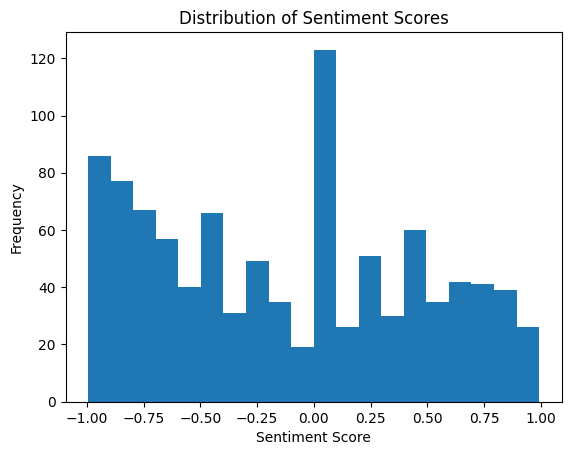

In [5]:


import matplotlib.pyplot as plt

sentiment_scores = df.select("sentiment_score").rdd.flatMap(lambda x: x).collect()
plt.hist(sentiment_scores, bins=20)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Scores")
plt.show()


# Zero Shot classification



In [8]:
import torch
from transformers import pipeline
from pyspark.sql import SparkSession

model_name = "facebook/bart-large-mnli"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_model(device):
    """Loads the zero-shot classification model."""
    return pipeline("zero-shot-classification", model=model_name, device=device)

news_sentiment_analysis = load_model(device)
sentiment_list = ["positive", "negative", "neutral", "joy", "sadness", "anger", "fear", "trust"]

def analyze_sentiment(article_str):
    """Analyzes sentiment of a given article string using zero-shot classification."""
    try:
        analysis_output = news_sentiment_analysis(
            article_str,
            candidate_labels=sentiment_list,
            multi_label=True
        )

        sentiments = {emotion: score for emotion, score in zip(analysis_output['labels'], analysis_output['scores'])}
        return sentiments
    except Exception as e:
        print(f"Error during sentiment analysis: {e}")
        return None

def fetch_news_data(spark, file_path):
    """Fetches news data from a JSON file in HDFS using PySpark."""
    try:
        df = spark.read.json(file_path)
        return df
    except Exception as e:
        print(f"Error reading JSON from HDFS: {e}")
        return None

def main():
    """Main function to orchestrate news data fetching and sentiment analysis."""
    # Initialize Spark session
    spark = SparkSession.builder.appName("NewsSentimentAnalysis").getOrCreate()

    # Define the file path for the JSON file in HDFS
    file_path = "hdfs://localhost:9000/user/atul/news_data/sentiment_output/news_data_1_sentiment.json"

    # Fetch news data from HDFS
    news_df = fetch_news_data(spark, file_path)

    if news_df is None:
        print("Failed to fetch news data. Exiting.")
        spark.stop()
        return

    # Collect news articles from DataFrame
    news_articles = news_df.collect()

    for row in news_articles:
        content = row.Summary

        # Analyze sentiment for the article content
        sentiments = analyze_sentiment(content)

        if sentiments:
            print(f"Sentiment analysis for article")
            print(sentiments)
        else:
            print(f"Sentiment analysis failed for article")

    spark.stop()

if __name__ == "__main__":
    main()


Device set to use cuda:0


Sentiment analysis for article
{'negative': 0.9890369176864624, 'fear': 0.5472390055656433, 'anger': 0.33015114068984985, 'sadness': 0.18441317975521088, 'trust': 0.16340258717536926, 'positive': 0.006028774660080671, 'neutral': 0.0014737406745553017, 'joy': 0.0010217699455097318}
Sentiment analysis for article
{'negative': 0.9750404357910156, 'anger': 0.9575838446617126, 'sadness': 0.4838597774505615, 'fear': 0.2800873816013336, 'trust': 0.21558575332164764, 'joy': 0.030577998608350754, 'positive': 0.012566940858960152, 'neutral': 0.002381126396358013}
Sentiment analysis for article
{'positive': 0.8595955967903137, 'negative': 0.462806761264801, 'trust': 0.34223976731300354, 'joy': 0.21821938455104828, 'anger': 0.006167537532746792, 'neutral': 0.005113210994750261, 'fear': 0.002848164178431034, 'sadness': 0.0004054067248944193}
Sentiment analysis for article
{'fear': 0.6263143420219421, 'sadness': 0.5758741497993469, 'anger': 0.4688871502876282, 'trust': 0.36973267793655396, 'negative

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sentiment analysis for article
{'negative': 0.9826472997665405, 'anger': 0.6818321347236633, 'trust': 0.6167786717414856, 'sadness': 0.3861669898033142, 'fear': 0.3381706178188324, 'positive': 0.05915523320436478, 'neutral': 0.006089230068027973, 'joy': 0.003954726736992598}
Sentiment analysis for article
{'negative': 0.9937630295753479, 'anger': 0.041749630123376846, 'joy': 0.005215131212025881, 'fear': 0.004939670208841562, 'positive': 0.0031512449495494366, 'sadness': 0.0022702321875840425, 'trust': 0.002256244421005249, 'neutral': 0.0012107217917218804}
Sentiment analysis for article
{'positive': 0.9871512055397034, 'joy': 0.772689163684845, 'trust': 0.33274343609809875, 'anger': 0.29851314425468445, 'negative': 0.2154880166053772, 'fear': 0.07472018897533417, 'neutral': 0.010393994860351086, 'sadness': 0.0027912138029932976}
Sentiment analysis for article
{'positive': 0.5450631976127625, 'trust': 0.32606735825538635, 'negative': 0.2732004225254059, 'joy': 0.1794530302286148, 'ange

KeyboardInterrupt: 

In [ ]:
# pip install torch torchvision torchaudio
# pip install transformers
# pip install tf-keras



Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 11.7 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 11.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 7.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 6.1 MB/s eta 0:00:008.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 10.2 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.sql.types import FloatType
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize SparkSession
spark = SparkSession.builder.appName("BatchSentimentAnalysis").getOrCreate()

# Download VADER lexicon if you haven't already
try:
    sid = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()

# Define the sentiment analysis function
def analyze_sentiment(text):
    if not text:
        return 0.0
    scores = sid.polarity_scores(text)
    return scores['compound']

# register the function as a UDF
analyze_sentiment_udf = udf(analyze_sentiment, FloatType())

# input and output paths
base_input_path = "hdfs://localhost:9000/user/atul/news_data/input/"
output_csv_path = "hdfs://localhost:9000/user/atul/news_data/zero_shot_output/sentiment_summary.csv"  

num_files = 871  # total number of files
all_data = []  # To collect all DataFrames

for i in range(1, num_files + 1):
    # Construct the file path
    input_file_path = f"{base_input_path}news_data_{i}.json"

    try:
        # Read the JSON file
        df = spark.read.json(input_file_path)

        # Check if the DataFrame is empty
        if df.count() == 0:
            print(f"Skipping empty file: {input_file_path}")
            continue

        # Preprocess and perform sentiment analysis (assuming a 'text' or 'Summary' column)
        # Adapt this to your actual column name
        text_column = "Summary"  # Or "Content" or whatever column holds the text

        # Check if the text_column exists
        if text_column not in df.columns:
            print(f"Skipping {input_file_path} as column {text_column} does not exist.")
            continue

        df = df.withColumn(text_column, lower(col(text_column)))
        df = df.withColumn(text_column, regexp_replace(col(text_column), "[^a-zA-Z0-9\\s]", ""))
        df = df.withColumn("sentiment_score", analyze_sentiment_udf(col(text_column)))

        # Select only the desired columns
        df_selected = df.select("Summary", "sentiment_score")

        all_data.append(df_selected)  # Collect the DataFrames
        print(f"Successfully processed: {input_file_path}")

    except Exception as e:
        print(f"Error processing {input_file_path}: {e}")

# Union all the DataFrames
if all_data:
    final_df = all_data[0]
    for df in all_data[1:]:
        final_df = final_df.union(df)


    # Write the combined DataFrame to a single CSV file
    final_df.coalesce(1).write.option("header", "true").mode("overwrite").csv(output_csv_path)
    print(f"Successfully combined and saved all data to: {output_csv_path}")
else:
    print("No data was processed.")

# Stop the SparkSession
spark.stop()
